In [1]:
import numpy as np
import pandas as pd
import os
print(os.listdir("../predict_future_sales/input/"))
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_importance

['sales_train.csv', 'Untitled.ipynb', 'shops.csv', 'test.csv', 'item_categories.csv', 'items.csv', 'sample_submission.csv']


In [2]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

In [3]:
pd.get_option("display.max_columns")

#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 120)
#現在の最大表示行数の出力
pd.get_option("display.max_rows")

#最大表示行数の指定（ここでは50行を指定）
pd.set_option('display.max_rows', 300)

In [4]:
DATA_FOLDER = '../predict_future_sales/input'

transactions = pd.read_csv('input/sales_train.csv')
items = pd.read_csv('input/items.csv')
item_categories = pd.read_csv('input/item_categories.csv')
shops = pd.read_csv(os.path.join(DATA_FOLDER,'shops.csv'))


In [5]:
test = pd.read_csv(os.path.join(DATA_FOLDER,'test.csv'))

In [6]:
transactions.head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


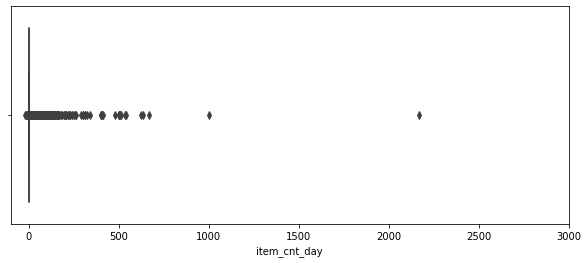

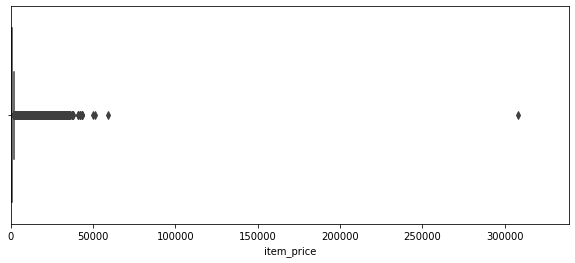

In [7]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=transactions.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(transactions.item_price.min(), transactions.item_price.max()*1.1)
sns.boxplot(x=transactions.item_price)

In [8]:
transactions = transactions[transactions.item_cnt_day < 1001]
transactions  = transactions[transactions.item_price < 100000]

In [9]:
items.head(5)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [10]:
item_categories.head(5)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [11]:
shops.head(10)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [12]:
shops['city_name'] = shops['shop_name'].map(lambda x:x.split(' ')[0])
shops['city_name'].value_counts()

Москва              13
Воронеж              3
Тюмень               3
РостовНаДону         3
Жуковский            2
Н.Новгород           2
Уфа                  2
Новосибирск          2
Казань               2
!Якутск              2
СПб                  2
Красноярск           2
Самара               2
Якутск               2
Чехов                1
Калуга               1
Адыгея               1
Омск                 1
Интернет-магазин     1
Курск                1
Химки                1
Томск                1
Цифровой             1
Сургут               1
Коломна              1
Мытищи               1
Сергиев              1
Ярославль            1
Волжский             1
Вологда              1
Выездная             1
Балашиха             1
Name: city_name, dtype: int64

In [13]:
shops.loc[shops['city_name'] == '!Якутск', 'city_name'] = 'Якутск'
shops.city_name.value_counts()

Москва              13
Якутск               4
РостовНаДону         3
Тюмень               3
Воронеж              3
Самара               2
СПб                  2
Красноярск           2
Казань               2
Жуковский            2
Н.Новгород           2
Уфа                  2
Новосибирск          2
Чехов                1
Томск                1
Калуга               1
Адыгея               1
Омск                 1
Интернет-магазин     1
Курск                1
Коломна              1
Сургут               1
Химки                1
Мытищи               1
Сергиев              1
Ярославль            1
Волжский             1
Вологда              1
Выездная             1
Цифровой             1
Балашиха             1
Name: city_name, dtype: int64

In [14]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [15]:
item_categories['split'] = item_categories['item_category_name'].str.split(' - ')
item_categories['type'] = item_categories['split'].map(lambda x:x[0].strip())
item_categories['subtype'] = item_categories['split'].map(lambda x:x[1].strip() if len(x) > 1 else x[0].strip())
item_categories['type'] = le.fit_transform(item_categories['type'])
item_categories['subtype'] = le.fit_transform(item_categories['subtype'])

item_categories = item_categories[['type','subtype','item_category_id']]

In [16]:
shops['city_name'] = le.fit_transform(shops['city_name'])

encoding = shops.groupby('city_name').size()
encoding = encoding / len(shops)
shops['city_frequency'] = shops.city_name.map(encoding)
shops.city_frequency.describe()

# encoding = test.groupby('item_id').size()
# encoding = encoding/len(test)
# test['item_freq'] = test.item_id.map(encoding)

# encoding = transactions.groupby('item_id').size()
# encoding = encoding/len(transactions)
# transactions['item_freq'] = transactions.item_id.map(encoding)

count    60.000000
mean      0.072778
std       0.077628
min       0.016667
25%       0.016667
50%       0.033333
75%       0.066667
max       0.216667
Name: city_frequency, dtype: float64

In [17]:
transactions = pd.merge(transactions, items, on='item_id', how='left')
transactions = transactions.drop('item_name',axis=1)
transactions.head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,02.01.2013,0,59,22154,999.00,1.0,37
1,03.01.2013,0,25,2552,899.00,1.0,58
2,05.01.2013,0,25,2552,899.00,-1.0,58
3,06.01.2013,0,25,2554,1709.05,1.0,58
4,15.01.2013,0,25,2555,1099.00,1.0,56


In [18]:
transactions = pd.merge(transactions, shops, on='shop_id', how='left')
transactions.head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,shop_name,city_name,city_frequency
0,02.01.2013,0,59,22154,999.00,1.0,37,"Ярославль ТЦ ""Альтаир""",30,0.016667
1,03.01.2013,0,25,2552,899.00,1.0,58,"Москва ТРК ""Атриум""",13,0.216667
2,05.01.2013,0,25,2552,899.00,-1.0,58,"Москва ТРК ""Атриум""",13,0.216667
3,06.01.2013,0,25,2554,1709.05,1.0,58,"Москва ТРК ""Атриум""",13,0.216667
4,15.01.2013,0,25,2555,1099.00,1.0,56,"Москва ТРК ""Атриум""",13,0.216667


In [19]:
from itertools import product
index_col = ['shop_id','item_id','date_block_num']

In [20]:
grid = []
for block_num in transactions['date_block_num'].unique():
    cur_shops = transactions.loc[transactions['date_block_num'] == block_num, 'shop_id'].unique()
    #This shows all shops in three countries working in each month
    cur_items = transactions.loc[transactions['date_block_num']==block_num,'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops,cur_items,[block_num]])),dtype='int32'))
grid = pd.DataFrame(np.vstack(grid),columns=index_col,dtype=np.int32)
grid.head(15)

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0
5,59,2565,0
6,59,2572,0
7,59,2573,0
8,59,2574,0
9,59,2593,0


## Make statistical features

In [21]:
mean_transactions = transactions.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day':'sum','item_price':np.mean}).reset_index()

mean_transactions.head(5)

,date_block_num,shop_id,item_id,item_cnt_day,item_price
0,0,0,32,6.0,221.0
1,0,0,33,3.0,347.0
2,0,0,35,1.0,247.0
3,0,0,43,1.0,221.0
4,0,0,51,2.0,128.5


In [22]:
mean_transactions.columns = ['date_block_num','shop_id','item_id','item_cnt_month','item_price']

In [23]:
mean_transactions.item_cnt_month.describe()

count    1.609123e+06
mean     2.265853e+00
std      8.466196e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      1.644000e+03
Name: item_cnt_month, dtype: float64

In [24]:
mean_transactions.item_cnt_month = mean_transactions.item_cnt_month.clip(0,20)
mean_transactions.item_cnt_month.describe()

count    1.609123e+06
mean     2.022807e+00
std      2.577964e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.000000e+01
Name: item_cnt_month, dtype: float64

In [25]:
mean_transactions = pd.merge(grid, mean_transactions, on=['date_block_num','shop_id','item_id'],how='left').fillna(0)
mean_transactions.head(10)

,shop_id,item_id,date_block_num,item_cnt_month,item_price
0,59,22154,0,1.0,999.0
1,59,2552,0,0.0,0.0
2,59,2554,0,0.0,0.0
3,59,2555,0,0.0,0.0
4,59,2564,0,0.0,0.0
5,59,2565,0,0.0,0.0
6,59,2572,0,0.0,0.0
7,59,2573,0,0.0,0.0
8,59,2574,0,2.0,399.0
9,59,2593,0,0.0,0.0


In [26]:
mean_transactions = pd.merge(mean_transactions, items, on='item_id',how='left')
mean_transactions.head(10)

,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_name,item_category_id
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59
5,59,2565,0,0.0,0.0,DEEP PURPLE Stormbringer (фирм.),56
6,59,2572,0,0.0,0.0,DEFTONES Koi No Yokan,55
7,59,2573,0,0.0,0.0,DEL REY LANA Born To Die,55
8,59,2574,0,2.0,399.0,DEL REY LANA Born To Die The Paradise Editio...,55
9,59,2593,0,0.0,0.0,DEPECHE MODE Music For The Masses,55


In [27]:
transactions['sales'] = transactions['item_cnt_day'] * transactions['item_price']

## I will make the similar dataframe about statistical features, but this time, these are lag features

In [28]:
item_mean =transactions.groupby(['item_id','date_block_num']).mean().reset_index()\
                        [['item_id','item_price','item_cnt_day','date_block_num','sales']]
item_mean.columns = ['item_id','item_price_per_item','item_cnt_day_per_item','date_block_num','sales_per_item']



item_std =transactions.groupby(['item_id','date_block_num']).std().reset_index()\
                        [['item_id','item_price','item_cnt_day','date_block_num','sales']]
item_std.columns = ['item_id','price_std_per_item','cnt_day_std_per_item','date_block_num','sales_std_per_item']

In [29]:
mean_transactions = pd.merge(mean_transactions, item_mean, on=['date_block_num','item_id'],how='left')
mean_transactions = pd.merge(mean_transactions, item_std, on=['date_block_num','item_id'],how='left')
mean_transactions.head(10)

,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_name,item_category_id,item_price_per_item,item_cnt_day_per_item,sales_per_item,price_std_per_item,cnt_day_std_per_item,sales_std_per_item
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37,999.000000,1.000000,999.000000,0.000000,0.000000,0.000000
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,899.000000,0.000000,0.000000,0.000000,1.414214,1271.377993
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,1709.050000,1.000000,1709.050000,NaN,NaN,NaN
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,1098.850000,1.000000,1098.850000,0.212132,0.000000,0.212132
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,327.600000,1.000000,327.600000,47.851855,0.000000,47.851855
5,59,2565,0,0.0,0.0,DEEP PURPLE Stormbringer (фирм.),56,549.000000,1.000000,549.000000,0.000000,0.000000,0.000000
6,59,2572,0,0.0,0.0,DEFTONES Koi No Yokan,55,284.333333,1.000000,284.333333,36.275044,0.000000,36.275044
7,59,2573,0,0.0,0.0,DEL REY LANA Born To Die,55,299.000000,1.142857,341.714286,0.000000,0.534522,159.822223
8,59,2574,0,2.0,399.0,DEL REY LANA Born To Die The Paradise Editio...,55,392.986538,1.144231,450.534615,25.217555,0.379531,155.777822
9,59,2593,0,0.0,0.0,DEPECHE MODE Music For The Masses,55,254.200000,1.000000,254.200000,55.454486,0.000000,55.454486


In [30]:
mean_transactions['product_sales'] = mean_transactions['item_cnt_month'] * mean_transactions['item_price']

In [31]:
del item_mean

In [32]:
shop_mean_df = transactions.groupby(['date_block_num','shop_id']).mean().reset_index()\
                                 [['shop_id','date_block_num','item_cnt_day','item_price','sales']]
shop_mean_df.columns = ['shop_id','date_block_num','item_cnt_day_per_shop','item_price_per_shop','sales_per_shop']
mean_transactions = pd.merge(mean_transactions,shop_mean_df, on=['date_block_num','shop_id'],how='left')

shop_std_df =  transactions.groupby(['date_block_num','shop_id']).std().reset_index()\
                                 [['shop_id','date_block_num','item_cnt_day','item_price','sales']]
shop_std_df.columns = ['shop_id','date_block_num','cnt_day_std_shop','price_std_per_shop','sales_std_per_shop']
mean_transactions = pd.merge(mean_transactions,shop_std_df, on=['date_block_num','shop_id'],how='left')

In [33]:
mean_transactions.head(10)

,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_name,item_category_id,item_price_per_item,item_cnt_day_per_item,sales_per_item,price_std_per_item,cnt_day_std_per_item,sales_std_per_item,product_sales,item_cnt_day_per_shop,item_price_per_shop,sales_per_shop,cnt_day_std_shop,price_std_per_shop,sales_std_per_shop
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37,999.000000,1.000000,999.000000,0.000000,0.000000,0.000000,999.0,1.092041,820.174553,884.369789,0.4467,1626.46851,1781.954779
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,899.000000,0.000000,0.000000,0.000000,1.414214,1271.377993,0.0,1.092041,820.174553,884.369789,0.4467,1626.46851,1781.954779
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,1709.050000,1.000000,1709.050000,NaN,NaN,NaN,0.0,1.092041,820.174553,884.369789,0.4467,1626.46851,1781.954779
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,1098.850000,1.000000,1098.850000,0.212132,0.000000,0.212132,0.0,1.092041,820.174553,884.369789,0.4467,1626.46851,1781.954779
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,327.600000,1.000000,327.600000,47.851855,0.000000,47.851855,0.0,1.092041,820.174553,884.369789,0.4467,1626.46851,1781.954779
5,59,2565,0,0.0,0.0,DEEP PURPLE Stormbringer (фирм.),56,549.000000,1.000000,549.000000,0.000000,0.000000,0.000000,0.0,1.092041,820.174553,884.369789,0.4467,1626.46851,1781.954779
6,59,2572,0,0.0,0.0,DEFTONES Koi No Yokan,55,284.333333,1.000000,284.333333,36.275044,0.000000,36.275044,0.0,1.092041,820.174553,884.369789,0.4467,1626.46851,1781.954779
7,59,2573,0,0.0,0.0,DEL REY LANA Born To Die,55,299.000000,1.142857,341.714286,0.000000,0.534522,159.822223,0.0,1.092041,820.174553,884.369789,0.4467,1626.46851,1781.954779
8,59,2574,0,2.0,399.0,DEL REY LANA Born To Die The Paradise Editio...,55,392.986538,1.144231,450.534615,25.217555,0.379531,155.777822,798.0,1.092041,820.174553,884.369789,0.4467,1626.46851,1781.954779
9,59,2593,0,0.0,0.0,DEPECHE MODE Music For The Masses,55,254.200000,1.000000,254.200000,55.454486,0.000000,55.454486,0.0,1.092041,820.174553,884.369789,0.4467,1626.46851,1781.954779


In [34]:
category_mean_df = transactions.groupby(['date_block_num','item_category_id']).mean().reset_index()[['item_category_id','date_block_num','item_cnt_day','item_price','sales']]
category_mean_df.columns = ['item_category_id','date_block_num','item_cnt_day_per_category','item_price_per_category','sales_per_category']
mean_transactions = pd.merge(mean_transactions, category_mean_df, on=['date_block_num','item_category_id'],how='left')

category_mean_df = transactions.groupby(['date_block_num','item_category_id']).std().reset_index()[['item_category_id','date_block_num','item_cnt_day','item_price','sales']]
category_mean_df.columns = ['item_category_id','date_block_num','cnt_day_std_per_category','price_std_per_category','sales_std_per_category']
mean_transactions = pd.merge(mean_transactions, category_mean_df, on=['date_block_num','item_category_id'],how='left')

In [35]:
shop_cat_df = transactions.groupby(['date_block_num', 'item_category_id', 'shop_id']).mean().reset_index()\
                          [['date_block_num', 'item_category_id', 'shop_id','item_cnt_day','item_price']]
shop_cat_df.columns = ['date_block_num','item_category_id','shop_id','cnt_day_shop_cat','price_shop_cat']
mean_transactions = pd.merge(mean_transactions, shop_cat_df, on=['date_block_num', 'item_category_id','shop_id'], how='left')

In [36]:
import gc 

def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [37]:
mean_transactions = downcast_dtypes(mean_transactions)
mean_transactions.head(10)

,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_name,item_category_id,item_price_per_item,item_cnt_day_per_item,sales_per_item,price_std_per_item,cnt_day_std_per_item,sales_std_per_item,product_sales,item_cnt_day_per_shop,item_price_per_shop,sales_per_shop,cnt_day_std_shop,price_std_per_shop,sales_std_per_shop,item_cnt_day_per_category,item_price_per_category,sales_per_category,cnt_day_std_per_category,price_std_per_category,sales_std_per_category,cnt_day_shop_cat,price_shop_cat
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37,999.000000,1.000000,999.000000,0.000000,0.000000,0.000000,999.0,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,1.053414,465.036011,491.797668,0.385709,334.376770,398.859619,1.016949,451.226776
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,899.000000,0.000000,0.000000,0.000000,1.414214,1271.378052,0.0,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,0.969595,1401.858154,1371.483154,0.265064,545.689636,641.605957,NaN,NaN
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,1709.050049,1.000000,1709.050049,NaN,NaN,NaN,0.0,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,0.969595,1401.858154,1371.483154,0.265064,545.689636,641.605957,NaN,NaN
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,1098.849976,1.000000,1098.849976,0.212132,0.000000,0.212132,0.0,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,1.007519,867.447021,876.650024,0.086547,335.257874,361.018921,1.000000,1299.000000
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,327.600006,1.000000,327.600006,47.851856,0.000000,47.851856,0.0,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,0.990113,443.330017,433.212769,0.202288,465.695496,484.760101,1.000000,1274.000000
5,59,2565,0,0.0,0.0,DEEP PURPLE Stormbringer (фирм.),56,549.000000,1.000000,549.000000,0.000000,0.000000,0.000000,0.0,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,1.007519,867.447021,876.650024,0.086547,335.257874,361.018921,1.000000,1299.000000
6,59,2572,0,0.0,0.0,DEFTONES Koi No Yokan,55,284.333344,1.000000,284.333344,36.275043,0.000000,36.275043,0.0,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,1.025878,265.640533,273.485382,0.193638,107.401657,127.452682,1.024242,272.652130
7,59,2573,0,0.0,0.0,DEL REY LANA Born To Die,55,299.000000,1.142857,341.714294,0.000000,0.534522,159.822220,0.0,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,1.025878,265.640533,273.485382,0.193638,107.401657,127.452682,1.024242,272.652130
8,59,2574,0,2.0,399.0,DEL REY LANA Born To Die The Paradise Editio...,55,392.986542,1.144231,450.534607,25.217554,0.379531,155.777817,798.0,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,1.025878,265.640533,273.485382,0.193638,107.401657,127.452682,1.024242,272.652130
9,59,2593,0,0.0,0.0,DEPECHE MODE Music For The Masses,55,254.199997,1.000000,254.199997,55.454487,0.000000,55.454487,0.0,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,1.025878,265.640533,273.485382,0.193638,107.401657,127.452682,1.024242,272.652130


In [38]:
mean_transactions.head(10)

,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_name,item_category_id,item_price_per_item,item_cnt_day_per_item,sales_per_item,price_std_per_item,cnt_day_std_per_item,sales_std_per_item,product_sales,item_cnt_day_per_shop,item_price_per_shop,sales_per_shop,cnt_day_std_shop,price_std_per_shop,sales_std_per_shop,item_cnt_day_per_category,item_price_per_category,sales_per_category,cnt_day_std_per_category,price_std_per_category,sales_std_per_category,cnt_day_shop_cat,price_shop_cat
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37,999.000000,1.000000,999.000000,0.000000,0.000000,0.000000,999.0,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,1.053414,465.036011,491.797668,0.385709,334.376770,398.859619,1.016949,451.226776
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,899.000000,0.000000,0.000000,0.000000,1.414214,1271.378052,0.0,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,0.969595,1401.858154,1371.483154,0.265064,545.689636,641.605957,NaN,NaN
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,1709.050049,1.000000,1709.050049,NaN,NaN,NaN,0.0,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,0.969595,1401.858154,1371.483154,0.265064,545.689636,641.605957,NaN,NaN
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,1098.849976,1.000000,1098.849976,0.212132,0.000000,0.212132,0.0,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,1.007519,867.447021,876.650024,0.086547,335.257874,361.018921,1.000000,1299.000000
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,327.600006,1.000000,327.600006,47.851856,0.000000,47.851856,0.0,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,0.990113,443.330017,433.212769,0.202288,465.695496,484.760101,1.000000,1274.000000
5,59,2565,0,0.0,0.0,DEEP PURPLE Stormbringer (фирм.),56,549.000000,1.000000,549.000000,0.000000,0.000000,0.000000,0.0,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,1.007519,867.447021,876.650024,0.086547,335.257874,361.018921,1.000000,1299.000000
6,59,2572,0,0.0,0.0,DEFTONES Koi No Yokan,55,284.333344,1.000000,284.333344,36.275043,0.000000,36.275043,0.0,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,1.025878,265.640533,273.485382,0.193638,107.401657,127.452682,1.024242,272.652130
7,59,2573,0,0.0,0.0,DEL REY LANA Born To Die,55,299.000000,1.142857,341.714294,0.000000,0.534522,159.822220,0.0,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,1.025878,265.640533,273.485382,0.193638,107.401657,127.452682,1.024242,272.652130
8,59,2574,0,2.0,399.0,DEL REY LANA Born To Die The Paradise Editio...,55,392.986542,1.144231,450.534607,25.217554,0.379531,155.777817,798.0,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,1.025878,265.640533,273.485382,0.193638,107.401657,127.452682,1.024242,272.652130
9,59,2593,0,0.0,0.0,DEPECHE MODE Music For The Masses,55,254.199997,1.000000,254.199997,55.454487,0.000000,55.454487,0.0,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,1.025878,265.640533,273.485382,0.193638,107.401657,127.452682,1.024242,272.652130


## Create Lag features 

In [39]:
#These are variables which are presented as lag features
lag_variables = list(mean_transactions.columns[7:]) + ['item_cnt_month']

lags= [1,2,3,6]
from tqdm import tqdm_notebook
for lag in tqdm_notebook(lags):
    sales_new_df = mean_transactions.copy()
    sales_new_df.date_block_num += lag
    sales_new_df = sales_new_df[['date_block_num','shop_id','item_id'] + lag_variables]
    sales_new_df.columns = ['date_block_num','shop_id','item_id'] + [lag_fest+'_lag_'+ str(lag) for lag_fest in lag_variables]
    mean_transactions = pd.merge(mean_transactions, sales_new_df, on = ['date_block_num','shop_id','item_id'],how='left')
    del sales_new_df

In [40]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id', col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col + '_lag_' + str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on = ['date_block_num','shop_id','item_id'] , how='left')
    return df

In [41]:
shops.drop('shop_name',axis=1)

,shop_id,city_name,city_frequency
0,0,29,0.066667
1,1,29,0.066667
2,2,0,0.016667
3,3,1,0.016667
4,4,2,0.016667
5,5,3,0.016667
6,6,4,0.050000
7,7,4,0.050000
8,8,4,0.050000
9,9,5,0.016667


In [42]:
mean_transactions = pd.merge(mean_transactions, shops, on=['shop_id'], how='left')

In [43]:
mean_transactions = pd.merge(mean_transactions, item_categories, on = ['item_category_id'], how='left')

In [44]:
# city_df = transactions.groupby(['date_block_num','city_name']).mean().reset_index()\
#                 [['date_block_num','city_name','item_cnt_day','item_price']]
# city_df.columns = ['date_block_num','city_name','item_cnt_day_city','item_price_city']
# mean_transactions = pd.merge(mean_transactions, city_df, on=['date_block_num','city_name'], how='left')

# mean_transactions = lag_feature(mean_transactions, [1,2,3,6],'item_cnt_day_city')
# mean_transactions = lag_feature(mean_transactions, [1,2,3,6],'item_price_city')

# lag_variables.extend(['item_cnt_day_city','item_price_city'])

In [45]:
mean_transactions.head(10)

,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_name,item_category_id,item_price_per_item,item_cnt_day_per_item,sales_per_item,price_std_per_item,cnt_day_std_per_item,sales_std_per_item,product_sales,item_cnt_day_per_shop,item_price_per_shop,sales_per_shop,cnt_day_std_shop,price_std_per_shop,sales_std_per_shop,item_cnt_day_per_category,item_price_per_category,sales_per_category,cnt_day_std_per_category,price_std_per_category,sales_std_per_category,cnt_day_shop_cat,price_shop_cat,item_price_per_item_lag_1,item_cnt_day_per_item_lag_1,sales_per_item_lag_1,price_std_per_item_lag_1,cnt_day_std_per_item_lag_1,sales_std_per_item_lag_1,product_sales_lag_1,item_cnt_day_per_shop_lag_1,item_price_per_shop_lag_1,sales_per_shop_lag_1,cnt_day_std_shop_lag_1,price_std_per_shop_lag_1,sales_std_per_shop_lag_1,item_cnt_day_per_category_lag_1,item_price_per_category_lag_1,sales_per_category_lag_1,cnt_day_std_per_category_lag_1,price_std_per_category_lag_1,sales_std_per_category_lag_1,cnt_day_shop_cat_lag_1,price_shop_cat_lag_1,item_cnt_month_lag_1,item_price_per_item_lag_2,item_cnt_day_per_item_lag_2,sales_per_item_lag_2,price_std_per_item_lag_2,cnt_day_std_per_item_lag_2,sales_std_per_item_lag_2,product_sales_lag_2,item_cnt_day_per_shop_lag_2,item_price_per_shop_lag_2,sales_per_shop_lag_2,...,price_std_per_shop_lag_2,sales_std_per_shop_lag_2,item_cnt_day_per_category_lag_2,item_price_per_category_lag_2,sales_per_category_lag_2,cnt_day_std_per_category_lag_2,price_std_per_category_lag_2,sales_std_per_category_lag_2,cnt_day_shop_cat_lag_2,price_shop_cat_lag_2,item_cnt_month_lag_2,item_price_per_item_lag_3,item_cnt_day_per_item_lag_3,sales_per_item_lag_3,price_std_per_item_lag_3,cnt_day_std_per_item_lag_3,sales_std_per_item_lag_3,product_sales_lag_3,item_cnt_day_per_shop_lag_3,item_price_per_shop_lag_3,sales_per_shop_lag_3,cnt_day_std_shop_lag_3,price_std_per_shop_lag_3,sales_std_per_shop_lag_3,item_cnt_day_per_category_lag_3,item_price_per_category_lag_3,sales_per_category_lag_3,cnt_day_std_per_category_lag_3,price_std_per_category_lag_3,sales_std_per_category_lag_3,cnt_day_shop_cat_lag_3,price_shop_cat_lag_3,item_cnt_month_lag_3,item_price_per_item_lag_6,item_cnt_day_per_item_lag_6,sales_per_item_lag_6,price_std_per_item_lag_6,cnt_day_std_per_item_lag_6,sales_std_per_item_lag_6,product_sales_lag_6,item_cnt_day_per_shop_lag_6,item_price_per_shop_lag_6,sales_per_shop_lag_6,cnt_day_std_shop_lag_6,price_std_per_shop_lag_6,sales_std_per_shop_lag_6,item_cnt_day_per_category_lag_6,item_price_per_category_lag_6,sales_per_category_lag_6,cnt_day_std_per_category_lag_6,price_std_per_category_lag_6,sales_std_per_category_lag_6,cnt_day_shop_cat_lag_6,price_shop_cat_lag_6,item_cnt_month_lag_6,shop_name,city_name,city_frequency,type,subtype
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37,999.000000,1.000000,999.000000,0.000000,0.000000,0.000000,999.0,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,1.053414,465.036011,491.797668,0.385709,334.376770,398.859619,1.016949,451.226776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Ярославль ТЦ ""Альтаир""",30,0.016667,11,1
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,899.000000,0.000000,0.000000,0.000000,1.414214,1271.378052,0.0,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,0.969595,1401.858154,1371.483154,0.265064,545.689636,641.605957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [46]:
mean_transactions = mean_transactions[mean_transactions['date_block_num'] > 12]

In [47]:
# encoder = mean_transactions.groupby('item_id').size()
# encoder = encoder/len(mean_transactions)

# mean_transactions['item_freq'] = mean_transactions['item_id'].map(encoder)

In [48]:
for feat in mean_transactions.columns:
    if 'cnt' in feat:
        mean_transactions[feat] = mean_transactions[feat].fillna(0)
    elif 'price' in feat:
        mean_transactions[feat] = mean_transactions[feat].fillna(mean_transactions[feat].median())

In [49]:
lag_variables.remove('item_cnt_month')
lag_variables

['item_price_per_item',
 'item_cnt_day_per_item',
 'sales_per_item',
 'price_std_per_item',
 'cnt_day_std_per_item',
 'sales_std_per_item',
 'product_sales',
 'item_cnt_day_per_shop',
 'item_price_per_shop',
 'sales_per_shop',
 'cnt_day_std_shop',
 'price_std_per_shop',
 'sales_std_per_shop',
 'item_cnt_day_per_category',
 'item_price_per_category',
 'sales_per_category',
 'cnt_day_std_per_category',
 'price_std_per_category',
 'sales_std_per_category',
 'cnt_day_shop_cat',
 'price_shop_cat']

In [50]:
cols_to_drop = lag_variables + ['item_price','item_name']
cols_to_drop

['item_price_per_item',
 'item_cnt_day_per_item',
 'sales_per_item',
 'price_std_per_item',
 'cnt_day_std_per_item',
 'sales_std_per_item',
 'product_sales',
 'item_cnt_day_per_shop',
 'item_price_per_shop',
 'sales_per_shop',
 'cnt_day_std_shop',
 'price_std_per_shop',
 'sales_std_per_shop',
 'item_cnt_day_per_category',
 'item_price_per_category',
 'sales_per_category',
 'cnt_day_std_per_category',
 'price_std_per_category',
 'sales_std_per_category',
 'cnt_day_shop_cat',
 'price_shop_cat',
 'item_price',
 'item_name']

## Trend features 

In [51]:
# group = mean_transactions.groupby(['item_id']).agg({'item_price':['mean']})
# group.columns = ['item_avg_item_price']
# group.reset_index(inplace=True)

# mean_transactions = pd.merge(mean_transactions, group, on=['item_id'], how='left')
# mean_transactions['item_avg_item_price'] = mean_transactions['item_avg_item_price'].astype(np.float16)
# lags  = [1,2,3,6]
# for i in lags:
#     mean_transactions['delta_price_lag_' + str(i)] = \
#     (mean_transactions['item_price_per_item_' + str(i)] - mean_transactions['item_avg_item_price'])/mean_transactions['item_avg_item_price']

# def select_trend(row):
#     for i in lags:
#         if row['delta_price_lag_' + str(i)]:
#             return row['delta_price_lag_' + str(i)]
#     return 0

# mean_transactions['delta_price_lag'] = mean_transactions.apply(select_trend, axis=1)
# #各行に対して最近のlag特徴量と平均値の差を計算し、その商品がどれほどホットなのかを計算する。
# mean_transactions['delta_price_lag'] = mean_transactions['delta_price_lag'].astype(np.float16).fillna(0, inplace=True)
# features_to_drop = ['item_avg_item_price']



## Special Features

In [52]:
# mean_transactions['month'] = mean_transactions['date_block_num'] % 12
# days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
# mean_transactions['days'] = mean_transactions['month'].map(days).astype(np.int8)

In [53]:
training = mean_transactions.drop(cols_to_drop,axis=1)

In [54]:
import xgboost as xgb

In [55]:
training = training.drop('shop_name',axis=1)

In [56]:
len(training.columns)

97

In [57]:
training.head(5)

,shop_id,item_id,date_block_num,item_cnt_month,item_category_id,item_price_per_item_lag_1,item_cnt_day_per_item_lag_1,sales_per_item_lag_1,price_std_per_item_lag_1,cnt_day_std_per_item_lag_1,sales_std_per_item_lag_1,product_sales_lag_1,item_cnt_day_per_shop_lag_1,item_price_per_shop_lag_1,sales_per_shop_lag_1,cnt_day_std_shop_lag_1,price_std_per_shop_lag_1,sales_std_per_shop_lag_1,item_cnt_day_per_category_lag_1,item_price_per_category_lag_1,sales_per_category_lag_1,cnt_day_std_per_category_lag_1,price_std_per_category_lag_1,sales_std_per_category_lag_1,cnt_day_shop_cat_lag_1,price_shop_cat_lag_1,item_cnt_month_lag_1,item_price_per_item_lag_2,item_cnt_day_per_item_lag_2,sales_per_item_lag_2,price_std_per_item_lag_2,cnt_day_std_per_item_lag_2,sales_std_per_item_lag_2,product_sales_lag_2,item_cnt_day_per_shop_lag_2,item_price_per_shop_lag_2,sales_per_shop_lag_2,cnt_day_std_shop_lag_2,price_std_per_shop_lag_2,sales_std_per_shop_lag_2,item_cnt_day_per_category_lag_2,item_price_per_category_lag_2,sales_per_category_lag_2,cnt_day_std_per_category_lag_2,price_std_per_category_lag_2,sales_std_per_category_lag_2,cnt_day_shop_cat_lag_2,price_shop_cat_lag_2,item_cnt_month_lag_2,item_price_per_item_lag_3,item_cnt_day_per_item_lag_3,sales_per_item_lag_3,price_std_per_item_lag_3,cnt_day_std_per_item_lag_3,sales_std_per_item_lag_3,product_sales_lag_3,item_cnt_day_per_shop_lag_3,item_price_per_shop_lag_3,sales_per_shop_lag_3,cnt_day_std_shop_lag_3,price_std_per_shop_lag_3,sales_std_per_shop_lag_3,item_cnt_day_per_category_lag_3,item_price_per_category_lag_3,sales_per_category_lag_3,cnt_day_std_per_category_lag_3,price_std_per_category_lag_3,sales_std_per_category_lag_3,cnt_day_shop_cat_lag_3,price_shop_cat_lag_3,item_cnt_month_lag_3,item_price_per_item_lag_6,item_cnt_day_per_item_lag_6,sales_per_item_lag_6,price_std_per_item_lag_6,cnt_day_std_per_item_lag_6,sales_std_per_item_lag_6,product_sales_lag_6,item_cnt_day_per_shop_lag_6,item_price_per_shop_lag_6,sales_per_shop_lag_6,cnt_day_std_shop_lag_6,price_std_per_shop_lag_6,sales_std_per_shop_lag_6,item_cnt_day_per_category_lag_6,item_price_per_category_lag_6,sales_per_category_lag_6,cnt_day_std_per_category_lag_6,price_std_per_category_lag_6,sales_std_per_category_lag_6,cnt_day_shop_cat_lag_6,price_shop_cat_lag_6,item_cnt_month_lag_6,city_name,city_frequency,type,subtype
4836056,27,15242,13,2.0,63,670.333313,1.000000,670.333313,86.000000,0.000000,86.000000,699.0,1.282588,933.352539,1162.221069,2.013348,1470.434204,3065.484375,1.072020,784.343811,832.338440,0.373894,466.045044,538.425720,1.057692,827.057678,1.0,699.000000,1.000000,699.000000,0.000000,0.000000,0.000000,699.0,1.386419,1065.680542,1771.667114,1.894252,1812.540527,9735.088867,1.297745,662.071777,761.287048,1.349082,457.279510,633.040527,1.107527,776.193542,1.0,685.00,1.000000,685.000000,44.271889,0.000000,44.271889,0.0,1.357345,892.269165,1344.281128,1.651885,1304.103882,9451.010742,1.065767,667.952271,684.672363,0.500523,419.512695,435.079193,1.056604,687.679260,0.0,699.0,1.000000,699.0,0.0,0.000000,0.000000,699.0,1.216049,667.358765,766.732483,1.084473,1016.664185,1269.759277,1.113456,471.065521,479.988922,0.455611,411.071411,441.469604,1.115942,549.242004,1.0,13,0.216667,14,43
4836057,27,15200,13,1.0,69,499.000000,1.000000,499.000000,0.000000,0.000000,NaN,0.0,1.282588,933.352539,1162.221069,2.013348,1470.434204,3065.484375,1.363158,396.134277,469.494812,0.878501,384.467377,408.167969,1.264706,431.294128,0.0,499.000000,1.000000,499.000000,0.000000,0.000000,NaN,0.0,1.386419,1065.680542,1771.667114,1.894252,1812.540527,9735.088867,1.590431,456.113739,612.319885,1.545376,362.141174,544.666626,1.421053,457.310516,0.0,318.25,0.000000,NaN,0.000000,0.000000,NaN,NaN,0.000000,988.499756,NaN,0.000000,1916.845581,NaN,0.000000,408.500458,NaN,0.000000,267.398346,NaN,0.000000,398.848480,0.0,499.0,1.000000,499.0,0.0,0.000000,0.000000,0.0,1.216049,667.358765,766.732483,1.084473,1016.664185,1269.759277,1.112040,529.262512,560.555176,0.395734,260.

In [58]:
training = downcast_dtypes(training)
test = downcast_dtypes(test)

In [59]:
X_train = training[training.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = training[training.date_block_num < 33]['item_cnt_month']
X_valid = training[training.date_block_num == 33].drop(['item_cnt_month'], axis=1)
y_valid = training[training.date_block_num == 33]['item_cnt_month']

In [60]:
Y_train[:5]

4836056    2.0
4836057    1.0
4836058    2.0
4836059    1.0
4836060    1.0
Name: item_cnt_month, dtype: float32

In [61]:
xgbtrain = xgb.DMatrix(X_train.values, Y_train.values)
xgbvalid = xgb.DMatrix(X_valid.values, y_valid.values)
evals = [(xgbtrain, 'train'), (xgbvalid, 'eval')]

In [62]:
params = {
          'max_depth':10,
          'subsample':0.8,
          'min_child_weight':300,
          'colsample_bytree':0.8,
          'eta':0.3,'num_round':1000,
          'seed':1,
          'silent':0,
          'eval_metric':'rmse'
         }
bst = xgb.train(params, xgbtrain, evals=evals, early_stopping_rounds=10, verbose_eval=10)

[01:19:59] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	train-rmse:1.05888	eval-rmse:1.04949
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[9]	train-rmse:0.844965	eval-rmse:0.931682


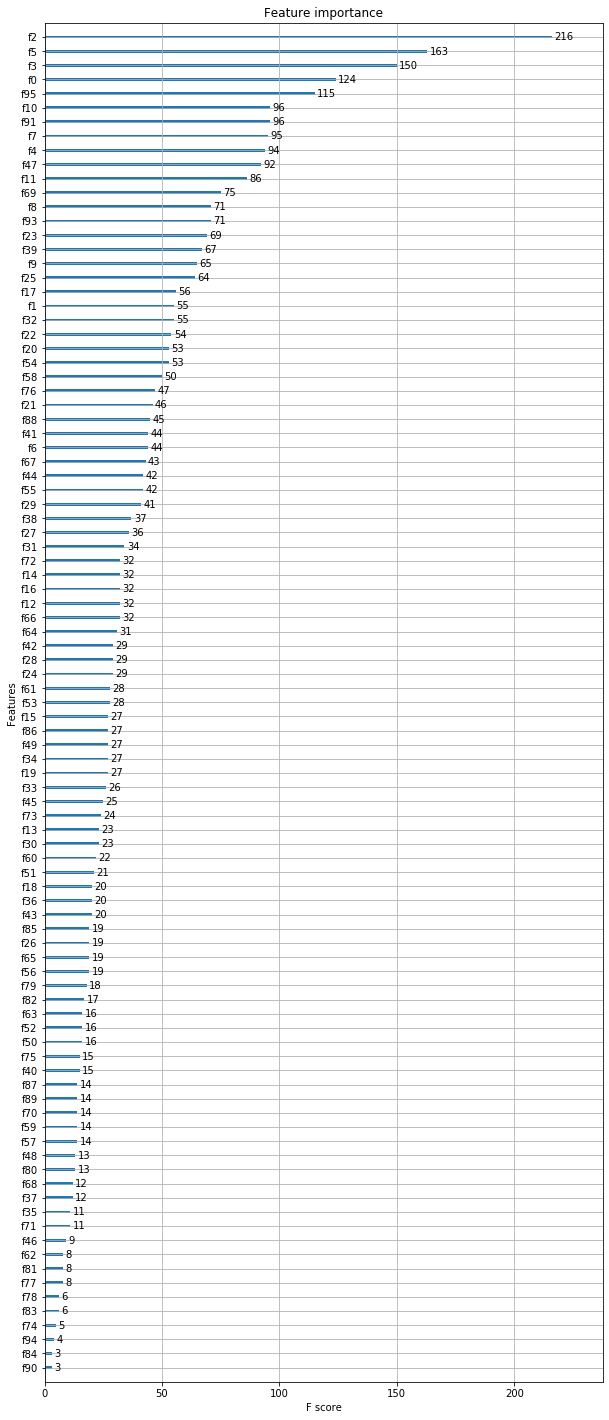

In [63]:
plot_features(bst, (10,25))

In [64]:
cols = list(training.columns)

del cols[cols.index('item_cnt_month')]
[cols[x] for x in [0,2,5,95,47,7,3,8,41]]

['shop_id',
 'date_block_num',
 'item_cnt_day_per_item_lag_1',
 'subtype',
 'item_cnt_month_lag_2',
 'price_std_per_item_lag_1',
 'item_category_id',
 'cnt_day_std_per_item_lag_1',
 'sales_per_category_lag_2']

In [65]:
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

In [66]:
category_feat = ['item_id','shop_id','item_category_id']

In [67]:
# X_train_lr = training.drop(category_feat + ['item_cnt_month'], axis=1)

# for feat in X_train_lr.columns:
#     X_train_lr[feat] = X_train_lr[feat].fillna(X_train_lr[feat].median())

In [68]:
# X_train_lr.date_block_num = X_train_lr.date_block_num.astype(str)
# X_train_lr.to_csv('lr_dataframe.csv',index=False)
# X_train_lr.date_block_num = pd.get_dummies(X_train_lr.date_block_num,sparse=False)      
# scaler = preprocessing.StandardScaler()

# X_train_lr = scaler.fit_transform(X_train_lr)

In [69]:
# lr = LinearRegression()

# lr.fit(X_train_lr, training['item_cnt_month'])

In [70]:
#ensembleのためにｃｓｖファイルに保存する
# training.to_csv('xgb_dataframe.csv',index=False)

In [71]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [72]:
 test['date_block_num'] = 34
# test['month'] = test['date_block_num'] % 12
# test['days'] = 31

In [73]:
test.head()

,ID,shop_id,item_id,date_block_num
0,0,5,5037,34
1,1,5,5320,34
2,2,5,5233,34
3,3,5,5232,34
4,4,5,5268,34


In [74]:
test = pd.merge(test, items, on=['item_id'], how='left')

In [75]:
lag_variables.append('item_cnt_month')
for lag in tqdm_notebook(lags):
    sales_new_df = mean_transactions.copy()
    sales_new_df.date_block_num += lag
    sales_new_df = sales_new_df[['date_block_num', 'shop_id','item_id'] + lag_variables]
    sales_new_df.columns = ['date_block_num','shop_id','item_id'] + [lag_feat + '_lag_'  + str(lag) for lag_feat in lag_variables]
    test = pd.merge(test, sales_new_df, on=['date_block_num','shop_id','item_id'],how='left')

In [76]:
test = pd.merge(test, shops, on=['shop_id'], how='left')

In [77]:
test = pd.merge(test,item_categories, on=['item_category_id'], how='left')

In [78]:
test.head(10)

,ID,shop_id,item_id,date_block_num,item_name,item_category_id,item_price_per_item_lag_1,item_cnt_day_per_item_lag_1,sales_per_item_lag_1,price_std_per_item_lag_1,cnt_day_std_per_item_lag_1,sales_std_per_item_lag_1,product_sales_lag_1,item_cnt_day_per_shop_lag_1,item_price_per_shop_lag_1,sales_per_shop_lag_1,cnt_day_std_shop_lag_1,price_std_per_shop_lag_1,sales_std_per_shop_lag_1,item_cnt_day_per_category_lag_1,item_price_per_category_lag_1,sales_per_category_lag_1,cnt_day_std_per_category_lag_1,price_std_per_category_lag_1,sales_std_per_category_lag_1,cnt_day_shop_cat_lag_1,price_shop_cat_lag_1,item_cnt_month_lag_1,item_price_per_item_lag_2,item_cnt_day_per_item_lag_2,sales_per_item_lag_2,price_std_per_item_lag_2,cnt_day_std_per_item_lag_2,sales_std_per_item_lag_2,product_sales_lag_2,item_cnt_day_per_shop_lag_2,item_price_per_shop_lag_2,sales_per_shop_lag_2,cnt_day_std_shop_lag_2,price_std_per_shop_lag_2,sales_std_per_shop_lag_2,item_cnt_day_per_category_lag_2,item_price_per_category_lag_2,sales_per_category_lag_2,cnt_day_std_per_category_lag_2,price_std_per_category_lag_2,sales_std_per_category_lag_2,cnt_day_shop_cat_lag_2,price_shop_cat_lag_2,item_cnt_month_lag_2,item_price_per_item_lag_3,item_cnt_day_per_item_lag_3,sales_per_item_lag_3,price_std_per_item_lag_3,cnt_day_std_per_item_lag_3,sales_std_per_item_lag_3,product_sales_lag_3,item_cnt_day_per_shop_lag_3,item_price_per_shop_lag_3,sales_per_shop_lag_3,cnt_day_std_shop_lag_3,price_std_per_shop_lag_3,sales_std_per_shop_lag_3,item_cnt_day_per_category_lag_3,item_price_per_category_lag_3,sales_per_category_lag_3,cnt_day_std_per_category_lag_3,price_std_per_category_lag_3,sales_std_per_category_lag_3,cnt_day_shop_cat_lag_3,price_shop_cat_lag_3,item_cnt_month_lag_3,item_price_per_item_lag_6,item_cnt_day_per_item_lag_6,sales_per_item_lag_6,price_std_per_item_lag_6,cnt_day_std_per_item_lag_6,sales_std_per_item_lag_6,product_sales_lag_6,item_cnt_day_per_shop_lag_6,item_price_per_shop_lag_6,sales_per_shop_lag_6,cnt_day_std_shop_lag_6,price_std_per_shop_lag_6,sales_std_per_shop_lag_6,item_cnt_day_per_category_lag_6,item_price_per_category_lag_6,sales_per_category_lag_6,cnt_day_std_per_category_lag_6,price_std_per_category_lag_6,sales_std_per_category_lag_6,cnt_day_shop_cat_lag_6,price_shop_cat_lag_6,item_cnt_month_lag_6,shop_name,city_name,city_frequency,type,subtype
0,0,5,5037,34,"NHL 15 [PS3, русские субтитры]",19,1499.00000,1.000000,1499.000000,0.000000,0.000000,0.000000,0.0,1.090155,1030.721924,1140.12439,0.449938,1654.235107,2012.336304,1.041791,1681.477905,1785.249023,0.304898,835.197998,1260.846924,1.013514,1548.945923,0.0,941.385193,1.428571,1258.038940,327.270966,1.657746,1266.470825,749.5,1.148265,1034.784302,1231.808594,0.877853,1661.687866,2667.791748,1.273688,1358.810913,1863.874756,1.332492,846.124573,3326.656006,1.195652,1355.232666,1.0,894.589844,1.190000,1036.971558,290.747772,0.544857,457.709259,2997.5,1.080134,921.702942,969.072205,0.41916,1669.297607,1915.93335,1.126207,1140.894653,1239.744751,0.519704,653.849548,765.679199,1.062016,1169.719482,3.0,1542.868774,1.087500,1656.543701,510.550049,0.284349,583.962952,1299.0,1.143503,958.609863,1171.629395,0.902971,1724.408203,3209.707275,1.061991,1419.183105,1494.353638,0.407311,679.342346,877.990784,1.013699,1316.797974,1.0,"Вологда ТРЦ ""Мармелад""",3,0.016667,5,12
1,1,5,5320,34,ONE DIRECTION Made In The A.M.,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Вологда ТРЦ ""Мармелад""",3,0.016667,13,4
2,2,5,5233,34,"Need for Speed Rivals (Essentials) [PS3, русск...",19,1199.00000,1.024390,1228.243896,0.000000,0.156174,187.252335,1199.0,1.090155,1030.721924,1140.12439,0.449938,1654.235107,2012.336304,1.041791,1681.4779

In [79]:
len(test.columns)

99

In [80]:
# encoder = test.groupby('item_id').size()
# encoder = encoder/len(test)

# test['item_freq'] = test['item_id'].map(encoder)

In [81]:
test = test.drop(['ID','item_name','shop_name'], axis=1)

In [82]:
for feat in test.columns:
    if 'cnt' in feat:
        test[feat] = test[feat].fillna(0)
    elif 'price' in feat:
        test[feat] = test[feat].fillna(test[feat].median())

In [83]:
# test.to_csv('xgb_test.csv',index=False)

In [84]:
xgbpredict = xgb.DMatrix(test.values)

In [85]:
len(test.columns)

96

In [86]:
diff = list(set(training.columns) - set(test.columns))
diff

['item_cnt_month']

In [87]:
pred = bst.predict(xgbpredict)

In [88]:
# X_test_lr = test.drop(category_feat, axis=1)

# for feat in X_test_lr.columns:
#     X_test_lr[feat] = X_test_lr[feat].fillna(X_test_lr[feat].median())

# X_test_lr["date_block_num"] = X_test_lr.date_block_num.astype(str)
# X_test_lr.to_csv('lr_test.csv',index=False)
# X_test_lr["date_block_num"] = pd.get_dummies(X_test_lr.date_block_num,sparse=False)

In [89]:
# X_test_lr = scaler.fit_transform(X_test_lr)
# pred_lr = lr.predict(X_test_lr)
# pred_lr = pred_lr.clip(0,20)

In [90]:
pd.Series(pred).describe()

count    214200.000000
mean          0.294325
std           0.700012
min          -0.270457
25%           0.057983
50%           0.115040
75%           0.261294
max          19.418411
dtype: float64

In [91]:
# pd.Series(pred_lr).describe()

In [92]:
pred = pred.clip(0,20)

## 標準偏差を付け加えた時と線形回帰とxbgboostの結果。スコアは0.98と1.10

In [93]:
pd.Series(pred).describe()

count    214200.000000
mean          0.294500
std           0.699933
min           0.000000
25%           0.057983
50%           0.115040
75%           0.261294
max          19.418411
dtype: float64

In [94]:
sub_df = pd.DataFrame({'ID':test.index,'item_cnt_month':pred})

In [95]:
# sub_lr_df = pd.DataFrame({'ID':test.index,'item_cnt_month':pred_lr})

In [96]:
sub_df.head()

,ID,item_cnt_month
0,0,0.398338
1,1,0.226130
2,2,1.558341
3,3,0.462983
4,4,3.109760


In [99]:
sub_df.to_csv('early_stop_xgb_type.csv',index=False)

In [98]:
#sub_lr_df.to_csv('lr_std.csv',index=False)